# Visualization Based on Data Gathered from Different Tasks
All results are generated from the machine with following configuration:
- CPU: Intel i7-8700K
- GPU: Nvidia GTX 1080Ti
- Memory: 32GB

In [539]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json
import csv

#### Step 1

The following cells show the result of pose estimation based on different image resolution. 

The image resolutions are ranging from 96x96 to 496x496, all multiples of 16.

The result data is located in folder 'step1'

Information of each column:
- `model`: What pose estimation model was used. In this case, I only used CMU model.
- `cocoyear`: This repository only works with COCO Dataset. `cocoyear` indicates what version of COCO Dataset was used.
- `resolution`: What resolution of each image in the dataset was converted before processing the pose estimation. For example, '96' represents '96x96'.
- `round`: I ran the pose estimation on each resolution 10 times. `round` indicates the times.
- `time_elapsed`: In seconds, how long does it take to run through the dataset.
- `AP1` ~ `AR5`: Represents 'average precision' and 'average recall'. They are 10 metrics indicating the quality of keypoint prediction. `1` means the predictions are exactly same as the ground truth of the dataset. `0` means the all keypoint prediction is off by a few standard deviation from the ground truth. For more information, see: [COCO Dataset explanation](http://cocodataset.org/#keypoints-eval)

In [540]:
col_info = ['model', 'cocoyear', 'resolution', 'round', 'time_elapsed',
            'AP1', 'AP2', 'AP3', 'AP4', 'AP5', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5']
df = pd.DataFrame(columns=col_info)

In [541]:
for i in range(6,32):
    res = i*16
    resolution = str(res)+'x'+str(res)
    filename = './step1/estimation_result_cmu_coco2017_%s.csv' % resolution

    with open(filename) as f:
        reader = csv.reader(f)
        round = 1
        for row in reader:
            precision_and_recall = row[0:10]
            time_elapsed = float(row[10])
            df = df.append(pd.Series(['cmu', 2017, res, round, time_elapsed,
                                      float(precision_and_recall[0]),
                                      float(precision_and_recall[1]),
                                      float(precision_and_recall[2]),
                                      float(precision_and_recall[3]),
                                      float(precision_and_recall[4]),
                                      float(precision_and_recall[5]),
                                      float(precision_and_recall[6]),
                                      float(precision_and_recall[7]),
                                      float(precision_and_recall[8]),
                                      float(precision_and_recall[9])], index=df.columns), ignore_index=True)
            round +=1

df

,model,cocoyear,resolution,round,time_elapsed,AP1,AP2,AP3,AP4,AP5,AR1,AR2,AR3,AR4,AR5
0,cmu,2017,96,1,155.992429,0.076224,0.171133,0.057660,0.002864,0.172485,0.098583,0.197733,0.089736,0.001912,0.230100
1,cmu,2017,96,2,157.988203,0.076224,0.171133,0.057660,0.002864,0.172485,0.098583,0.197733,0.089736,0.001912,0.230100
2,cmu,2017,96,3,151.602616,0.076224,0.171133,0.057660,0.002864,0.172485,0.098583,0.197733,0.089736,0.001912,0.230100
3,cmu,2017,96,4,155.027639,0.076224,0.171133,0.057660,0.002864,0.172485,0.098583,0.197733,0.089736,0.001912,0.230100
4,cmu,2017,96,5,158.488631,0.076224,0.171133,0.057660,0.002864,0.172485,0.098583,0.197733,0.089736,0.001912,0.230100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,cmu,2017,496,6,428.543510,0.441225,0.720170,0.449806,0.412471,0.479092,0.498945,0.740554,0.519364,0.421087,0.608956
256,cmu,2017,496,7,428.181316,0.441225,0.720170,0.449806,0.412471,0.479092,0.498945,0.740554,0.519364,0.421087,0.608956
257,cmu,2017,496,8,428.393865,0.441225,0.720170,0.449806,0.412471,0.479092,0.498945,0.740554,0.519364,0.421087,0.608956
258,cmu,2017,496,9,429.243396,0.441225,0.720170,0.449806,0.412471,0.479092,0.498945,0.740554,0.519364,0.421087,0.608956


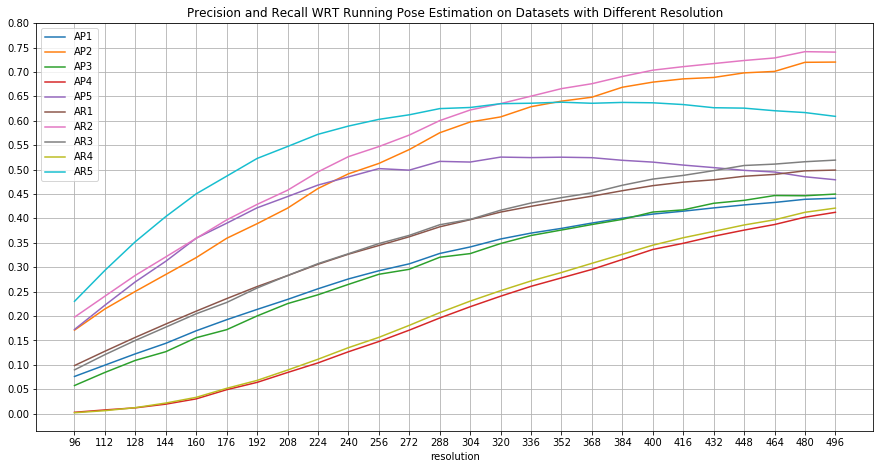

In [542]:
xticks = np.arange(96, 512, 16)
yticks = np.arange(0.0, 0.85, 0.05)
df_new = (df.loc[df['round']==1]).drop(columns=['time_elapsed', 'round', 'model', 'cocoyear'])
plot = df_new.plot(x='resolution', xticks=xticks, yticks = yticks, grid=True, figsize=(15,7.5), title='Precision and Recall WRT Running Pose Estimation on Datasets with Different Resolution')
fig = plot.get_figure()
fig.savefig('step1_precision_and_recall.png', dpi=200)

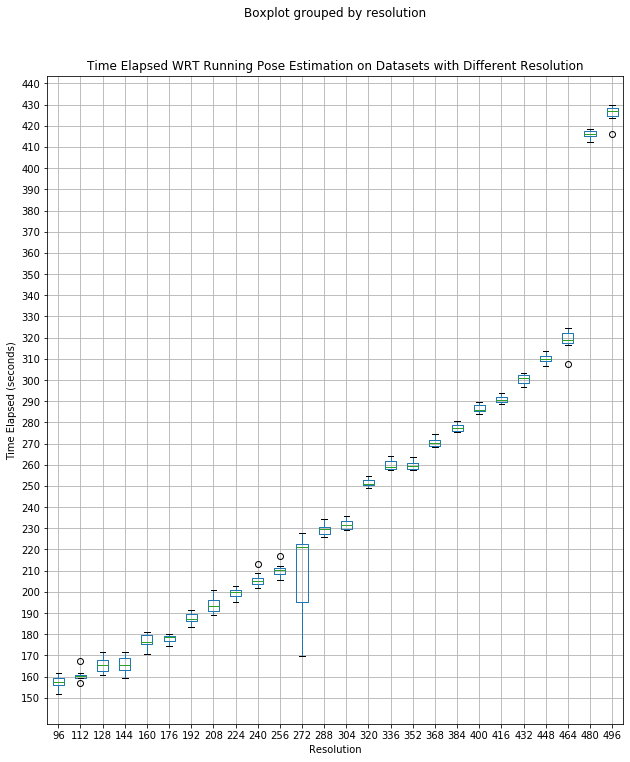

In [543]:
boxplot = df[['resolution','time_elapsed','round']].boxplot(by='resolution', figsize=(10,12))

boxplot.set_ylabel('Time Elapsed (seconds)')
boxplot.set_xlabel('Resolution')
boxplot.set_title('Time Elapsed WRT Running Pose Estimation on Datasets with Different Resolution')
yticks = np.arange(150, 450, 10)
boxplot.set_yticks(yticks)

fig = boxplot.get_figure()
fig.savefig('step1_time_elapsed.png', dpi=300)

#### Step 2: Running face detection on the Original COCO Dataset.

The model has a parameter called `number_of_times_to_upsample` – It determines how many times to upsample the image looking for faces. Higher numbers find smaller faces. I can only run the model with maximum `number_of_times_to_upsample` of 2. If higher, it will report a "out of memory" error.

The result data is located in 'step2' folder.

Information of each column:
- `face_detected`: How many faces are detected from the entire dataset.
- `time_elapsed`: In seconds, how long does it take to run through the dataset.
- `upsample`: `number_of_times_to_upsample` parameter in the face detection model. Only 0, 1, or 2.
- `round`: The face detection model were run 15 times for each `upsample` value. `round` indicates the times.

##### The dataset used in this step was COCO Dataset 2017.

In [544]:
col_info_2 = ['face_detected', 'time_elapsed', 'upsample', 'round']
df_2 = pd.DataFrame(columns=col_info_2)

In [545]:
for i in range(0,3):
    filename = './step2/face_detection_time_report_upsample_%s.csv' % i

    with open(filename) as f:
        reader = csv.reader(f)
        round = 1
        for row in reader:
            face_detected = int(row[0])
            time_elapsed = float(row[1])
            df_2 = df_2.append(pd.Series([face_detected, time_elapsed, i, round], index=df_2.columns), ignore_index=True)
            round +=1

df_2

,face_detected,time_elapsed,upsample,round
0,537.0,27.375759,0.0,1.0
1,537.0,26.950835,0.0,2.0
2,537.0,26.959489,0.0,3.0
3,537.0,26.958896,0.0,4.0
4,537.0,26.950530,0.0,5.0
5,537.0,26.951022,0.0,6.0
6,537.0,26.954669,0.0,7.0
7,537.0,26.953110,0.0,8.0
8,537.0,26.946444,0.0,9.0
9,537.0,26.943110,0.0,10.0


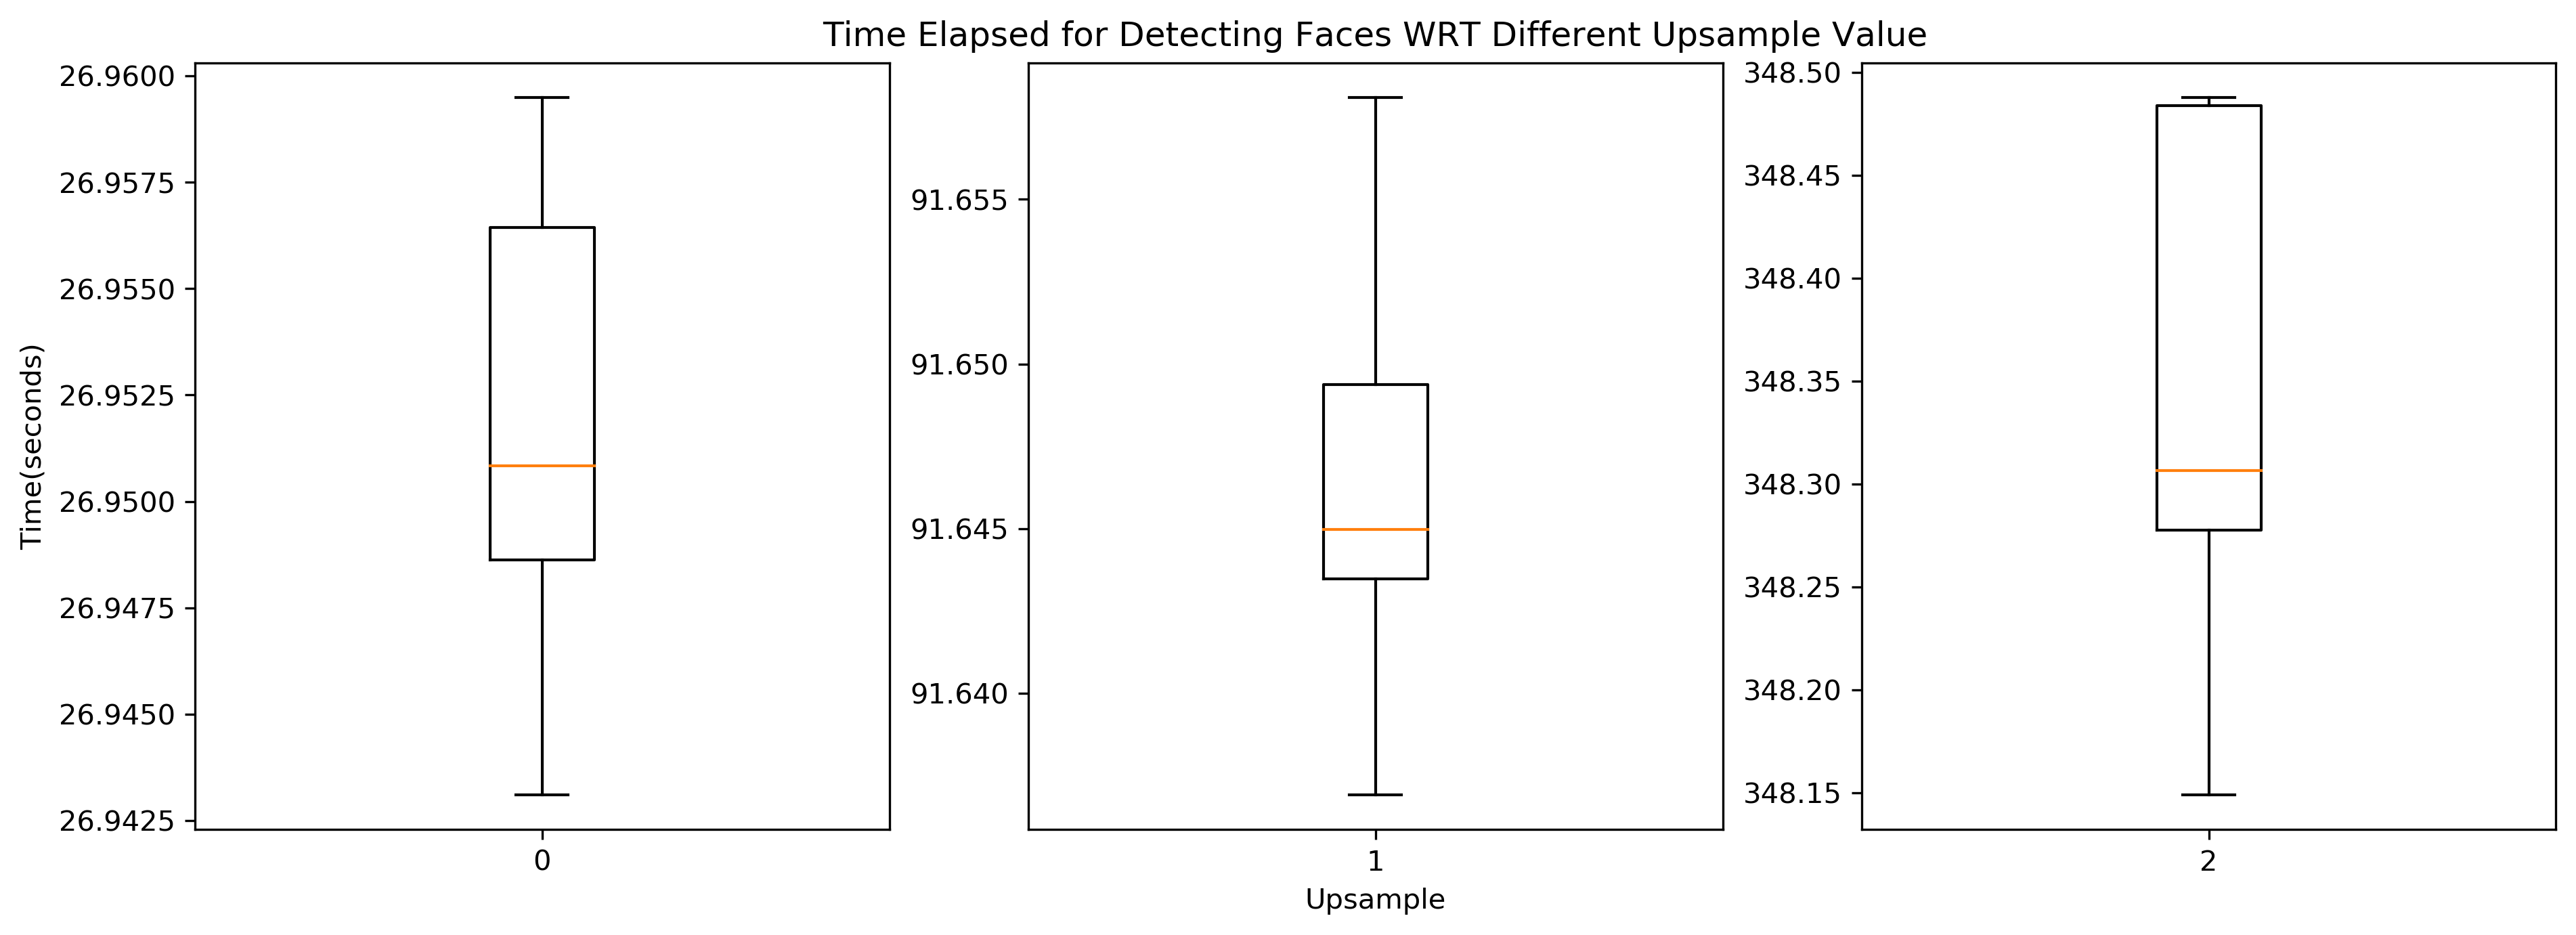

In [546]:
x = (0,1,2,3)
fig = plt.figure(figsize=[15,5],dpi=300)
ax1=plt.subplot(1, 3, 1)
ax1.boxplot(x = (df_2.loc[df_2['upsample']==0])[['time_elapsed']].values, showfliers=False, labels=[0,])
ax1.set_ylabel('Time(seconds)')
ax2=plt.subplot(1, 3, 2)
ax2.boxplot(x = (df_2.loc[df_2['upsample']==1])[['time_elapsed']].values, showfliers=False, labels=[1,])
ax2.set_title('Time Elapsed for Detecting Faces WRT Different Upsample Value')
ax2.set_xlabel('Upsample')
ax3=plt.subplot(1, 3, 3)
ax3.boxplot(x = (df_2.loc[df_2['upsample']==2])[['time_elapsed']].values, showfliers=False, labels=[2,])

plt.show()
fig.savefig('step2_time_elapsed.png', dpi=300)

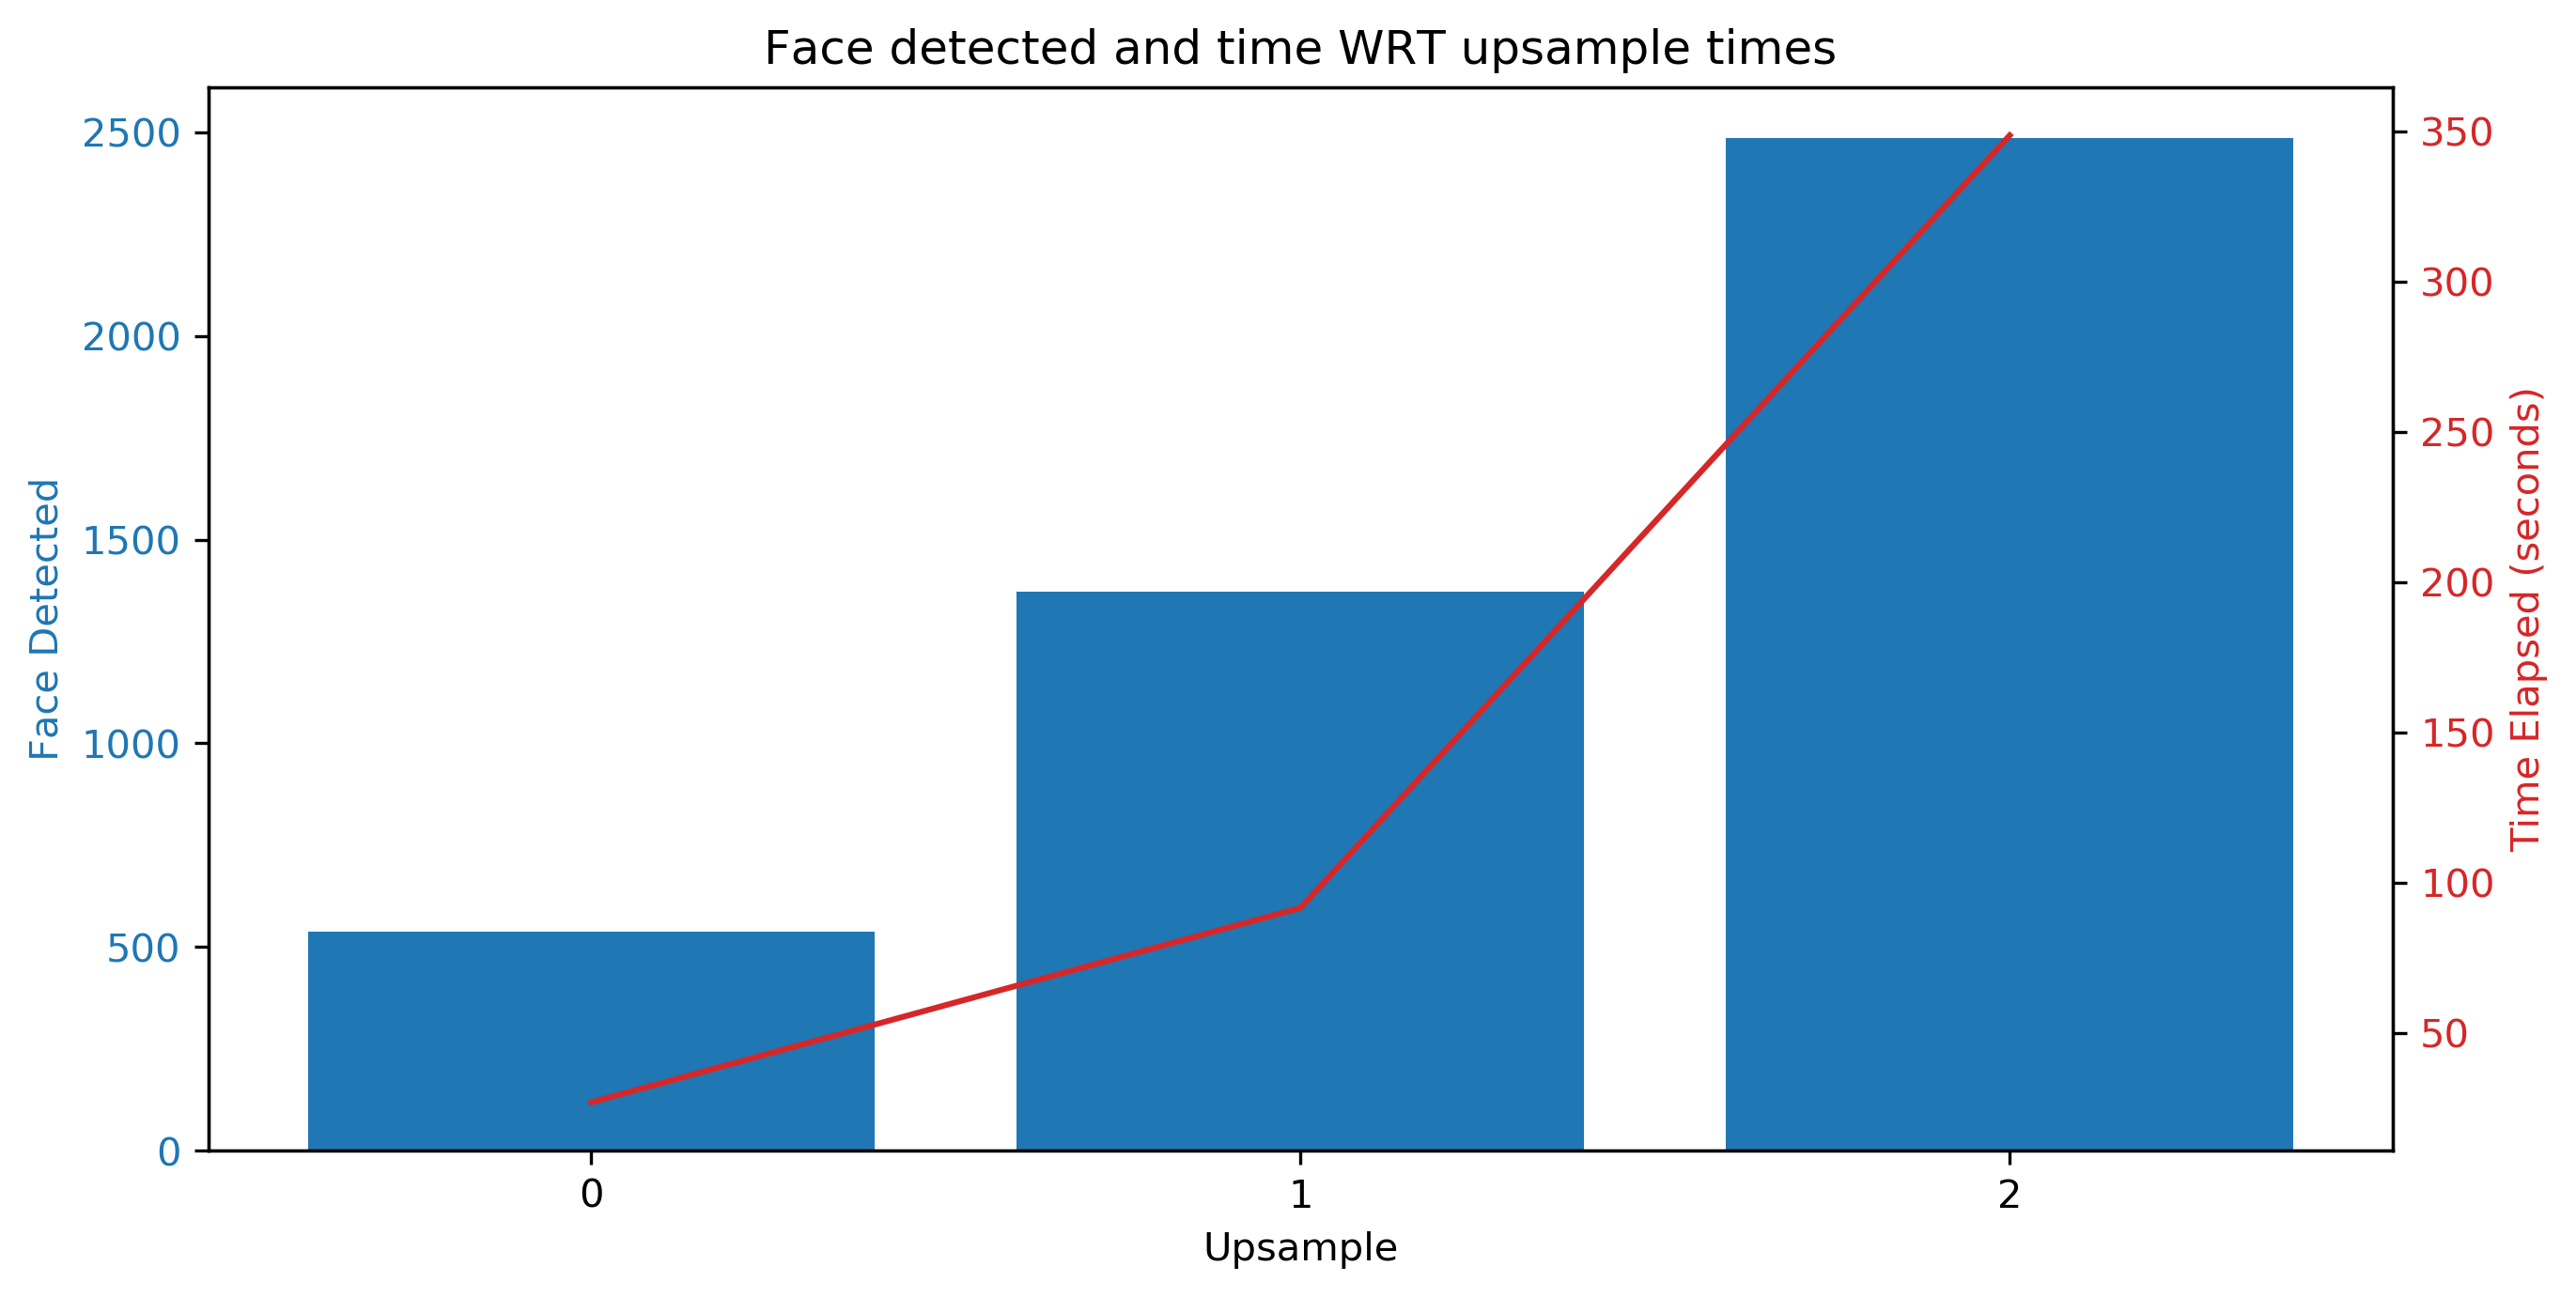

In [547]:
#Plotting the data
fig = plt.figure(figsize=[10,5],dpi=300)
ax1 = plt.subplot()
color = 'tab:blue'
ax1.set_title('Face detected and time WRT upsample times')
ax1.set_xlabel('Upsample')
ax1.set_ylabel('Face Detected', color=color)
ax1.bar(df_2['upsample'], df_2['face_detected'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Time Elapsed (seconds)', color=color)

#In this graph, the mean of 'time_elapsed' for each upsample value was plotted
ax2.plot((df_2.loc[df_2['round']==1])['upsample'], 
         (df_2.groupby('upsample', as_index=False)['time_elapsed'].mean())['time_elapsed'], color=color)


ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xticks((0,1,2))
plt.show()
fig.savefig('step2_face_detected.png', dpi=300)

#### Step 3: Blur the FACES in the dataset using Gaussian Blur. Then run pose estimation again on blurred dataset.

##### The faces are detected using `upsample` == 2.

The Gaussian Blur algorithm has a parameter called `radius`, the higher the value, the more the image is blurred

The following cells show the result of pose estimation on datasets that are blurred with different `radius` value(ranging from 1 to 20).

The pose estimation model used here is cmu model, with resolution of 432x368, which is the default resolution.

The result data is located in folder 'step3'.

Information for each column:
- `blur_radius`: Radius of Gaussian Blur. The higher the value, the more the faces are blurred.
- `round`: For each `blur_radius` value, the pose estimation model was run 10 times.
- `time_elapsed`: In seconds, how long does it take to run through the dataset.
- `AP1` ~ `AR5`: Represents 'average precision' and 'average recall'. They are 10 metrics indicating the quality of keypoint prediction. `1` means the predictions are exactly same as the ground truth of the dataset. `0` means the all keypoint prediction is off by a few standard deviation from the ground truth. For more information, see: [COCO Dataset explanation](http://cocodataset.org/#keypoints-eval)

In [548]:
col_info_3 = ['blur_radius', 'round', 'time_elapsed', 'AP1', 'AP2', 'AP3', 'AP4', 'AP5', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5']
df_3 = pd.DataFrame(columns=col_info_3)
for i in range(1,21):
    filename = './step3/estimation_result_432x368_2_%s.csv' % i
    with open(filename) as f:
        reader = csv.reader(f)
        round = 1
        for row in reader:
            precision_and_recall = row[0:10]
            time_elapsed = float(row[10])
            df_3 = df_3.append(pd.Series([i, round, time_elapsed,
                                      float(precision_and_recall[0]),
                                      float(precision_and_recall[1]),
                                      float(precision_and_recall[2]),
                                      float(precision_and_recall[3]),
                                      float(precision_and_recall[4]),
                                      float(precision_and_recall[5]),
                                      float(precision_and_recall[6]),
                                      float(precision_and_recall[7]),
                                      float(precision_and_recall[8]),
                                      float(precision_and_recall[9])], index=df_3.columns), ignore_index=True)
            round +=1

df_3

,blur_radius,round,time_elapsed,AP1,AP2,AP3,AP4,AP5,AR1,AR2,AR3,AR4,AR5
0,1.0,1.0,277.911038,0.417272,0.680644,0.427407,0.338475,0.532268,0.471363,0.702613,0.488035,0.347528,0.644036
1,1.0,2.0,276.709753,0.417272,0.680644,0.427407,0.338475,0.532268,0.471363,0.702613,0.488035,0.347528,0.644036
2,1.0,3.0,276.337232,0.417272,0.680644,0.427407,0.338475,0.532268,0.471363,0.702613,0.488035,0.347528,0.644036
3,1.0,4.0,278.871592,0.417272,0.680644,0.427407,0.338475,0.532268,0.471363,0.702613,0.488035,0.347528,0.644036
4,1.0,5.0,275.507458,0.417272,0.680644,0.427407,0.338475,0.532268,0.471363,0.702613,0.488035,0.347528,0.644036
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,20.0,6.0,274.494107,0.320904,0.603711,0.301002,0.285943,0.365431,0.376023,0.632872,0.372953,0.295630,0.487105
196,20.0,7.0,273.748701,0.320904,0.603711,0.301002,0.285943,0.365431,0.376023,0.632872,0.372953,0.295630,0.487105
197,20.0,8.0,273.390772,0.320904,0.603711,0.301002,0.285943,0.365431,0.376023,0.632872,0.372953,0.295630,0.487105
198,20.0,9.0,274.872612,0.320904,0.603711,0.301002,0.285943,0.365431,0.376023,0.632872,0.372953,0.295630,0.487105


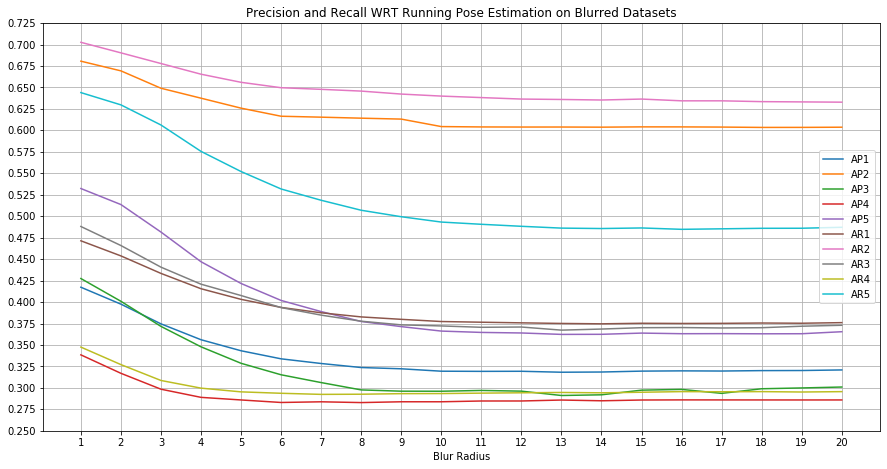

In [549]:
xticks = np.arange(1, 21, 1)
yticks = np.arange(0.25, 0.75, 0.025)
df_new = (df_3.loc[df_3['round']==1]).drop(columns=['time_elapsed', 'round'])
plot = df_new.plot(x='blur_radius', xticks=xticks, yticks=yticks, grid=True, figsize=(15,7.5),
                   title='Precision and Recall WRT Running Pose Estimation on Blurred Datasets')
plot.set_xlabel('Blur Radius')
fig = plot.get_figure()
fig.savefig('step3_precision_and_recall_wrt_blur_radius.png', dpi=300)

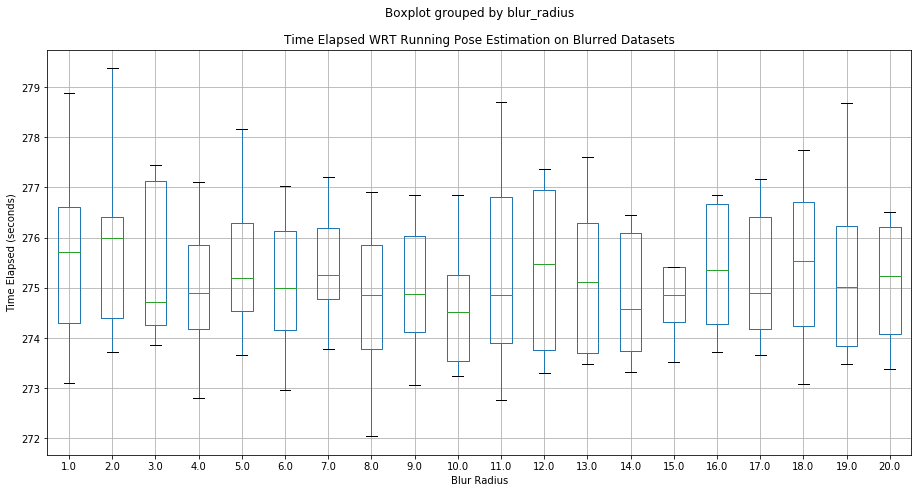

In [550]:
boxplot = df_3[['blur_radius','time_elapsed','round']].boxplot(column='time_elapsed', 
                                                               by='blur_radius', figsize=(15,7.5), showfliers=False)
boxplot.set_ylabel('Time Elapsed (seconds)')
boxplot.set_xlabel('Blur Radius')
boxplot.set_title('Time Elapsed WRT Running Pose Estimation on Blurred Datasets')


fig = boxplot.get_figure()
fig.savefig('step3_time_elapsed.png', dpi=300)

#### Step 4: Run face detection model on blurred datasets

After the datasets being blurred with different `radius`, run the face detection model again to see how many faces it still can detect.

The face detection model uses value of 2 on `number_of_times_to_upsample`.

The result data is located in folder 'step4' (except the result of detecting original dataset (radius==0) is in 'step2' folder)

Information for each column:
- `face_detected`: How many faces are detected after running through the dataset.
- `time_elapsed`: In seconds, how long does it take to run through the dataset.
- `blur_radius`: The dataset was blurred by what radius of Gaussian Blur. The higher the value, the more the faces are blurred. `blur_radius`==0 means no blurring(original dataset).
- `round`: For each blurred dataset, the face detection model was run 5 times. For the original dataset, the face detection model was run 15 times

In [567]:
col_info_4 = ['face_detected', 'time_elapsed', 'blur_radius', 'round']
df_4 = pd.DataFrame(columns=col_info_4)

for i in range(0,21):
    filename = './step4/detect_blurred_faces_upsample_2_radius_%s.csv' % str(i)
    if i == 0:
        filename = './step2/face_detection_time_report_upsample_2.csv'
    with open(filename) as f:
        reader = csv.reader(f)
        round = 1
        for row in reader:
            face_detected = int(row[0])
            time_elapsed = float(row[1])
            df_4 = df_4.append(pd.Series([face_detected, time_elapsed, i, round], index=df_4.columns), ignore_index=True)
            round +=1
df_4.iloc[45:55,]

,face_detected,time_elapsed,blur_radius,round
45,172.0,345.226570,7.0,1.0
46,172.0,345.512210,7.0,2.0
47,172.0,345.145698,7.0,3.0
48,172.0,345.379017,7.0,4.0
49,172.0,345.224607,7.0,5.0
50,137.0,345.198446,8.0,1.0
51,137.0,345.503906,8.0,2.0
52,137.0,345.153443,8.0,3.0
53,137.0,345.352973,8.0,4.0
54,137.0,345.285822,8.0,5.0


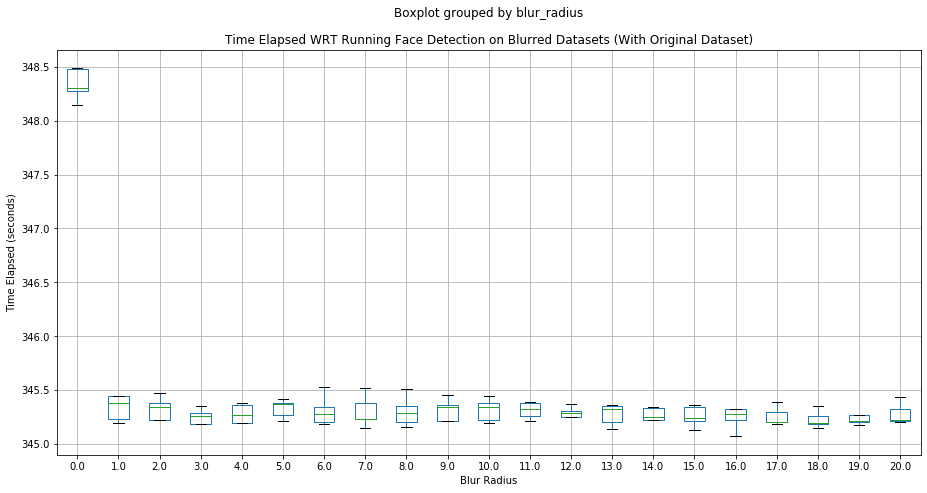

In [552]:
boxplot = df_4[['blur_radius','time_elapsed','round']].boxplot(column='time_elapsed', 
                                                               by='blur_radius', figsize=(15,7.5), showfliers=False)
boxplot.set_ylabel('Time Elapsed (seconds)')
boxplot.set_xlabel('Blur Radius')
boxplot.set_title('Time Elapsed WRT Running Face Detection on Blurred Datasets (With Original Dataset)')


fig = boxplot.get_figure()
fig.savefig('step4_time_elapsed_with_origin_dataset.png', dpi=300)

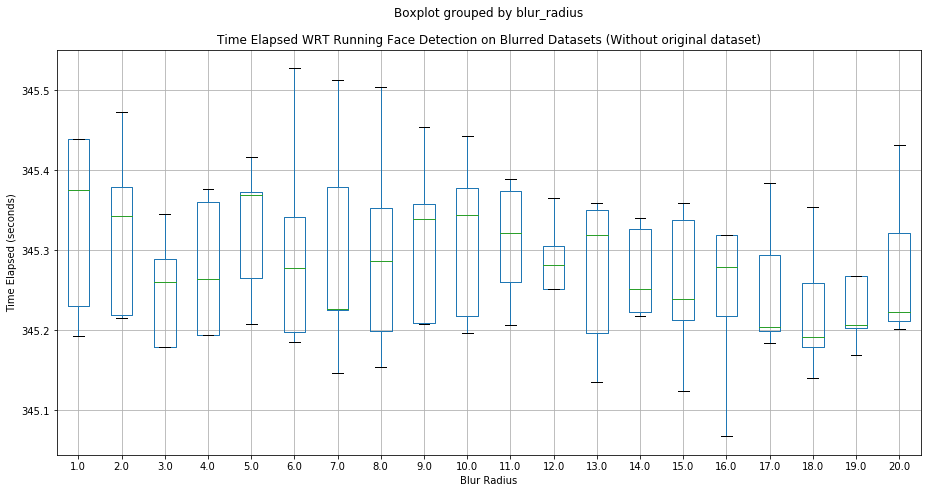

In [553]:
boxplot = df_4.loc[df_4['blur_radius']!=0][['blur_radius','time_elapsed','round']].boxplot(column='time_elapsed', 
                                                               by='blur_radius', figsize=(15,7.5), showfliers=False)
boxplot.set_ylabel('Time Elapsed (seconds)')
boxplot.set_xlabel('Blur Radius')
boxplot.set_title('Time Elapsed WRT Running Face Detection on Blurred Datasets (Without original dataset)')


fig = boxplot.get_figure()
fig.savefig('step4_time_elapsed_without_origin_dataset.png', dpi=300)

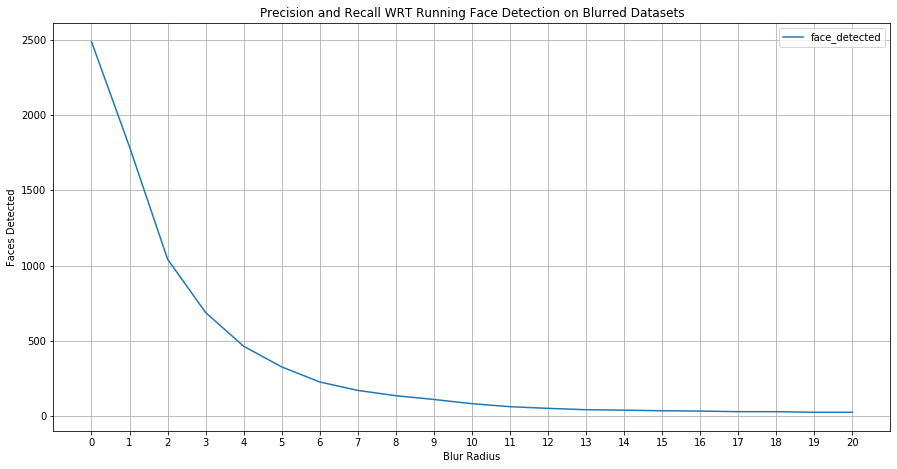

In [554]:
xticks = np.arange(0, 21, 1)
df_new = (df_4.loc[df_4['round']==1]).drop(columns=['time_elapsed', 'round'])

plot = df_new.plot(x = 'blur_radius', xticks=xticks, grid=True, figsize=(15,7.5),
                   title='Precision and Recall WRT Running Face Detection on Blurred Datasets')
plot.set_xlabel('Blur Radius')
plot.set_ylabel('Faces Detected')
fig = plot.get_figure()
fig.savefig('step4_face_detection_wrt_blur_radius.png', dpi=300)